In [51]:
import sklearn
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

In [52]:
data = io.loadmat("ex4data1.mat")
X = data["X"]
y = data["y"]
print(X.shape)

(5000, 400)


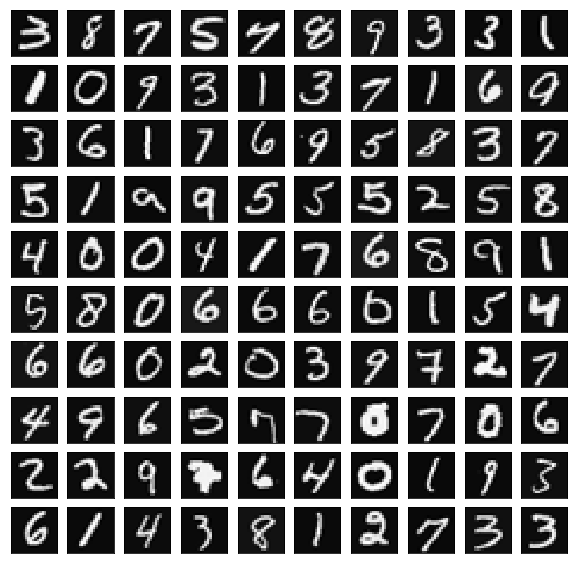

In [53]:
def plot_data():
    sample = np.random.choice(range(0, X.shape[0]), size= 100).flatten()
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.reshape(X[sample[i], :], (20, 20)).T, cmap="gray")
        ax.set(xticks=[], yticks=[])
plot_data()

In [113]:
def add_ones_column_to_X(X):
    new_X = np.ones((X.shape[0], X.shape[1] + 1))
    new_X[:, 1:] = X
    return new_X
X_ready = add_ones_column_to_X(X)
X_ready.shape

(5000, 401)

In [92]:
ex4_weights = io.loadmat("ex4weights.mat")
theta1_pre = ex4_weights["Theta1"]
theta2_pre = ex4_weights["Theta2"]

# Store the shape for the functions
thetas_shape = []
thetas_shape.append(theta1_pre.shape)
thetas_shape.append(theta2_pre.shape)
print(thetas_shape)

X_shape = X.shape
y_shape = y.shape

def reshape_thetas(thetas_flattened):
    thetas_ls = []
    left_point = 0
    for i in range(0, len(thetas_shape)):
        rows, columns = thetas_shape[i]
        theta_ar = np.reshape(thetas_flattened[left_point:left_point + rows*columns], (rows, columns))
        thetas_ls.append(theta_ar)
        left_point = rows*columns
    return thetas_ls

def reshape_X(X):
    return np.reshape(X, X_shape)

def reshape_y(y):
    return np.reshape(y, y_shape)

[(25, 401), (10, 26)]


In [96]:
y_new = y.copy()
y_new[y.flatten() == 10] = 0
y_new

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]], dtype=uint8)

In [58]:
def transform_y_to_dummy_columns(y):
    # Can change this to deal with the matlab has no 0 vals and the y-value is 10
    y_true_vals = np.zeros((y.shape[0], np.max(y)))
    for i in range(0, y.shape[0]):
        y_true_vals[i, y[i] - 1] = 1
    return y_true_vals

In [59]:
from scipy.special import expit
def h(thetas_ls, X):
    """
    Theta will be a list of arrays,
    each array will be another theta
    for the system.
    """ 
    # First layers activation is X
    activation_vals = X.T
    
    for theta in thetas_ls:
        activation_vals = add_ones_column_to_X(activation_vals.T).T
        z = np.dot(theta, activation_vals)
        activation_vals = expit(z)
    return activation_vals.T
        
def nnCostFunction(theta_flattened, X, y):
    theta_ls = reshape_thetas(theta_flattened)
    X_ar = reshape_X(X)
    y_ar = reshape_y(y)
    
    number_of_output_nodes = np.max(y_ar)
    y_dum = transform_y_to_dummy_columns(y_ar)
    J = 0.0
    h_theta = h(theta_ls, X_ar)
    for k in range(0, number_of_output_nodes):
        first_term = -y_dum[:, k]*np.log(h_theta[:, k])
        second_term = - (1 - y_dum[:, k])*np.log(1 - h_theta[:, k])
        J +=first_term + second_term
    m = X_ar.shape[0]
    return np.sum(J)/m

theta_whole = [theta1_pre, theta2_pre]
h(theta_whole, X)

theta_flattened = list(theta1_pre.flatten()) + list(theta2_pre.flatten())
nnCostFunction(theta_flattened, X.flatten(), y.flatten())


0.2876291651613189

In [60]:
def nnCostRegularizationFunction(theta_flattened, X, y, lambda_val=1):
    theta_ls = reshape_thetas(theta_flattened)
    X_ar = reshape_X(X)
    y_ar = reshape_y(y)
    
    number_of_output_nodes = np.max(y_ar)
    y_dum = transform_y_to_dummy_columns(y_ar)
    J = 0.0
    h_theta = h(theta_ls, X_ar)
    for k in range(0, number_of_output_nodes):
        first_term = -y_dum[:, k]*np.log(h_theta[:, k])
        second_term = - (1 - y_dum[:, k])*np.log(1 - h_theta[:, k])
        J +=first_term + second_term
        
    m = X_ar.shape[0]
    J = np.sum(J)/m
    # For regularization
    for theta in theta_ls:
        J += lambda_val*np.sum(theta[:,1:]**2)/(2*m)
    return J

nnCostRegularizationFunction(theta_flattened, X.flatten(), y.flatten())

0.38376985909092365

In [61]:
def sigmoidGradient(z):
    return expit(z)*(1-expit(z))
print("0: {}".format(sigmoidGradient(0)))
print("infinity: {}".format(sigmoidGradient(np.inf)))
print("negative infinity: {}".format(sigmoidGradient(-np.inf)))
sigmoidGradient(np.zeros((2,2)))

0: 0.25
infinity: 0.0
negative infinity: 0.0


array([[0.25, 0.25],
       [0.25, 0.25]])

In [72]:
def obtain_rand_Thetas(epsilon_init=0.12):
    length = 0
    for dims in thetas_shape:
        length += dims[0]*dims[1]
    theta_np = np.random.uniform(low=-epsilon_init, high=epsilon_init, size=length)
    return np.array(theta_np.flatten())

def feed_forward(thetas_ls, X):
    """
    Gives the activation of all but the input layer
    """
    activation_vals = X.T
    activation_vals_ls = []
    z_ls = []
    i=0
    for theta in thetas_ls:
        activation_vals = add_ones_column_to_X(activation_vals.T).T
        z = np.dot(theta, activation_vals)
        z_ls.append(z)
        activation_vals = expit(z)
        activation_vals_ls.append(activation_vals.T)
        i += 1
    return activation_vals_ls, z_ls

In [90]:
def random_thetas(size, epsilon=0.12):
    return np.random.uniform(low=-epsilon, high=epsilon, size=size)

def back_propagation(theta_flattened, X, y, lambda_val = 0):
    theta_ls = reshape_thetas(theta_flattened)
    X_ar = reshape_X(X)
    y_ar = reshape_y(y)

    Delta1 = np.zeros((25, 400 + 1))
    Delta2 = np.zeros((10, 25 + 1))
    m = X_ar.shape[0]
    for i in range(0, m):        
        # Current row is a row vector
        current_row = np.reshape(X_ar[i, :], (1,400))
        
        activation_vals_ls, z_ls = feed_forward(theta_ls, current_row)
        current_row = add_ones_column_to_X(current_row)
        
        del_3 = np.reshape(activation_vals_ls[1], (-1, 1)) - np.reshape(transform_y_to_dummy_columns(y_ar)[i, :], (-1, 1))
        
        temp_grad = np.ones((z_ls[0].shape[0] + 1, z_ls[0].shape[1]))
        temp_grad[1:, :] = z_ls[0]
        del_2 = theta_ls[1].T.dot(del_3) * sigmoidGradient(temp_grad)
        
        activation_vals_ls[0] = add_ones_column_to_X(activation_vals_ls[0])
        Delta1 = Delta1 + del_2[1:, :].dot(current_row)
        Delta2 = Delta2 + del_3.dot(activation_vals_ls[0])
        
    Delta1 = Delta1/m
    Delta2 = Delta2/m
    
    Delta1[1:, :] = Delta1[1:, :] + (lambda_val/m)*theta_ls[0][1:, :]
    Delta2[1:, :] = Delta2[1:, :] + (lambda_val/m)*theta_ls[1][1:, :]
    return np.array(Delta1.flatten().tolist() + Delta2.flatten().tolist())
        
back_prop_res = back_propagation(theta_flattened, X.flatten(), y.flatten())

10285


KeyboardInterrupt: 

In [32]:
def computeNumericalGradient(J,theta_flattened, X, y, bp_res, lambda_val = 1.0):
    numgrad = np.zeros(len(theta_flattened))
    perturb = np.zeros(len(theta_flattened))
    e = 1e-4

    for p in range(0, 10):
        x = np.random.randint(0, len(theta_flattened))
        perturb[x] = e
        loss1 = J(theta_flattened - perturb, X, y, lambda_val)
        loss2 = J(theta_flattened + perturb, X, y, lambda_val)
        
        grad = (loss2 - loss1)/(2*e)
        perturb[x] = 0
        print("Element: {}. Numerical gradient {:.7f}. Backpropagation Gradient {:.7f}".format(x, grad, bp_res[x]))
    return
    
gradient = computeNumericalGradient(nnCostRegularizationFunction, theta_flattened, X.flatten(), y.flatten(), back_prop_res, 0)

Element: 2588. Numerical gradient 0.0000435. Backpropagation Gradient 0.0000435
Element: 7805. Numerical gradient 0.0000597. Backpropagation Gradient 0.0000597
Element: 906. Numerical gradient 0.0000650. Backpropagation Gradient 0.0000650
Element: 6257. Numerical gradient -0.0000506. Backpropagation Gradient -0.0000506
Element: 8550. Numerical gradient 0.0001501. Backpropagation Gradient 0.0001501
Element: 7670. Numerical gradient 0.0000565. Backpropagation Gradient 0.0000565
Element: 6113. Numerical gradient -0.0000600. Backpropagation Gradient -0.0000600
Element: 9275. Numerical gradient -0.0000052. Backpropagation Gradient -0.0000052
Element: 4461. Numerical gradient 0.0000012. Backpropagation Gradient 0.0000012
Element: 6512. Numerical gradient 0.0000224. Backpropagation Gradient 0.0000224


In [33]:
back_prop_regularization_res = back_propagation(theta_flattened,
                                                X.flatten(),
                                                y.flatten(),
                                                1)
gradient = computeNumericalGradient(nnCostRegularizationFunction,
                                    theta_flattened,
                                    X.flatten(),
                                    y.flatten(),
                                    back_prop_regularization_res,
                                    1.0)

Element: 6494. Numerical gradient -0.0000590. Backpropagation Gradient -0.0000590
Element: 2782. Numerical gradient -0.0000056. Backpropagation Gradient -0.0000056
Element: 9349. Numerical gradient -0.0000971. Backpropagation Gradient -0.0000971
Element: 2807. Numerical gradient 0.0000165. Backpropagation Gradient 0.0000097
Element: 7285. Numerical gradient 0.0000317. Backpropagation Gradient 0.0000317
Element: 7899. Numerical gradient -0.0000054. Backpropagation Gradient -0.0000054
Element: 7631. Numerical gradient -0.0000001. Backpropagation Gradient -0.0000001
Element: 4231. Numerical gradient 0.0000157. Backpropagation Gradient 0.0000157
Element: 3939. Numerical gradient 0.0000704. Backpropagation Gradient 0.0000704
Element: 8293. Numerical gradient 0.0000394. Backpropagation Gradient 0.0000394


In [64]:
from scipy.optimize import fmin_cg

In [93]:
def NN_fit(lambda_val = 1.0):    
    theta_initial = obtain_rand_Thetas()
    results = fmin_cg(nnCostRegularizationFunction,
                      x0=theta_initial,
                      fprime=back_propagation,
                      maxiter=50,
                      full_output=True,
                      args=(np.array(X.flatten()), np.array(y.flatten()), lambda_val))
    return results
fmin_results = NN_fit(0)

10285
         Current function value: 0.282956
         Iterations: 50
         Function evaluations: 111
         Gradient evaluations: 111


In [95]:
theta_ls = reshape_thetas(fmin_results[0])

In [137]:
# Taken from https://github.com/kaleko/CourseraML.git, thanks for the assistance!
def NN_predict(theta_ls, row):
    activation_ls, _ = feed_forward(theta_ls, row)
    row_prediction = activation_ls[1]
    max_arg = np.argmax(row_prediction)
    return [1, 2, 3, 4, 5, 6, 7, 8, 9, 0][max_arg]
def compute_accuracy(X, y, theta_ls, verbose=False):
    n_correct = 0
    for row in range(0, X.shape[0]):
        result = NN_predict(theta_ls, X[row, :].reshape((1, -1)))
        if verbose:
            print("result: {}. y: {}, equal: {}".format(result, y[row][0], (result == y[row])[0]))
        if result == y[row]:
            n_correct += 1
    print("Accuracy {}".format((n_correct/X.shape[0])*100))

In [138]:
compute_accuracy(X, y_new, theta_ls)

Accuracy 96.54


In [139]:
compute_accuracy(X, y_new, theta_ls, verbose=True)

result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 0, equal: True
result: 0. y: 

result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 2, equal: True
result: 2. y: 

result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 1. y: 4, equal: False
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 9. y: 4, equal: False
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 9. y: 4, equal: False
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 4. y: 4, equal: True
result: 2. y: 4, equal: False
result: 4. y: 4, equal: True
result: 4.

result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 5. y: 6, equal: False
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y: 6, equal: True
result: 6. y:

result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 7. y: 9, equal: False
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: 9, equal: True
result: 9. y: